# Pauli Blocking correction
### Summary in case I come back:

This correction seems quite plausible, and gives nice results if interpreted as a ratio of PB fd to fd, but the issue is SMT has Boltzmann, not FD, which gives crazy high T dependence. Is this just an issue of details? If I include a good chemical potential, the full φn, will it work out? The issue is this is significantly more complicated, then requiring at least a 2D fit over g and η, rather than the 1D fit of SMT over g, if not even more than 2D. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv

import sys
sys.path.insert(0, "C:\\Users\zachc\Documents\GitHub")
import SMT.core.transport as SMT
from SMT.core.physical_constants import *
from SMT.core.physical_parameters import rs_from_n, Degeneracy_Parameter

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler


mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100

/tmp/ipykernel_3834814/473732583.py:7: RuntimeWarning: overflow encountered in exp
  f_fd = lambda eps: 1/(1 + np.exp(eps-eta))
/tmp/ipykernel_3834814/473732583.py:14: RuntimeWarning: overflow encountered in exp
  f_fd = lambda eps: 1/(1 + np.exp(eps-eta))


(1.0959596793105735, 1000.0)

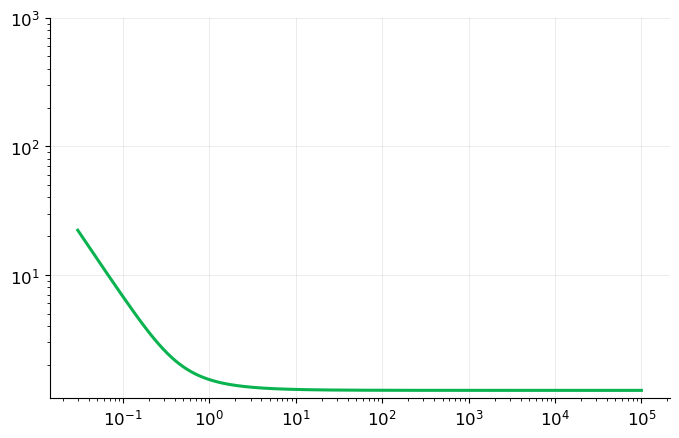

In [20]:
# First try
from scipy.integrate import quad
from scipy.optimize import curve_fit

@np.vectorize
def sigma_integral(eta):    
    f_fd = lambda eps: 1/(1 + np.exp(eps-eta))  
    integral = lambda eps: f_fd(eps)*np.sqrt(eps)
    int_of_theta = quad(integral, 0, 1e4 )
    return int_of_theta[0]

@np.vectorize
def sigma_integral_PB(eta):    
    f_fd = lambda eps: 1/(1 + np.exp(eps-eta))  
    integral = lambda eps: (1-f_fd(eps))*f_fd(eps)*np.sqrt(eps)
    int_of_theta = quad(integral, 0, 1e4 )
    return int_of_theta[0]

fig, ax  = plt.subplots()

theta_array = np.geomspace(3e-2,1e5, num=1000)
sigma_f = sigma_integral(1/theta_array)
sigma_f_PB = sigma_integral_PB(1/theta_array)


# a=1
# b=1.5
# c=0.99
# n=2
f_approx = lambda theta, a, b, n: b*(1 + (a/theta)**n)**(1/n)
# popt, pcov = curve_fit(f_approx,theta_array, sigma_f/sigma_f_PB, p0=[1, 1,1] ) 
# print(popt)
# ax.plot(theta_array, f_approx(theta_array, *popt))
# ax.plot(theta_array, f_approx(theta_array, 1,1))
ax.plot(theta_array, sigma_f/sigma_f_PB)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(None,1e3)


##
$$K_{nm}(g) = g^m \int^\infty_0 d\omega  e^{-g \omega^2} \omega^{2m+3} \phi_n(\omega)$$
Now let $-g \omega^2 = -\beta \epsilon$, so $\epsilon $
This means Boltzmann factor 
$$f_B = e^{-g \omega^2} = e^{-\beta \epsilon},$$
can be turned into the F-D distribution, as
$$f_{F-D} = 1/( 1 + e^{g \omega^2 - \eta} )$$
for $\eta \equiv \beta E_F $

Assuming now that $\phi_n(g)\sim A_n$, for some constant A. Then with $\epsilon=g \omega^2$
$$K_{nm}(g) = \frac{A_n}{2 g^{2}} \int^\infty_0 d\epsilon  e^{-\epsilon} \epsilon^{m+1} $$
which becomes 
$$K_{nm}(g) = \frac{A_n}{2 g^{2}} \int^\infty_0 d\epsilon f_{FD}(\epsilon, \eta) \epsilon^{m+1} $$
for Fermi-Dirac, 
$$
 f_{FD = \frac{1}{1 + e^{\epsilon - \eta}}
$$
and 
$$K_{nm}(g) = \frac{A_n}{2 g^{2}} \int^\infty_0 d\epsilon (1-f_{FD}) f_{FD}   \epsilon^{m+1} $$
for the Pauli blocked version


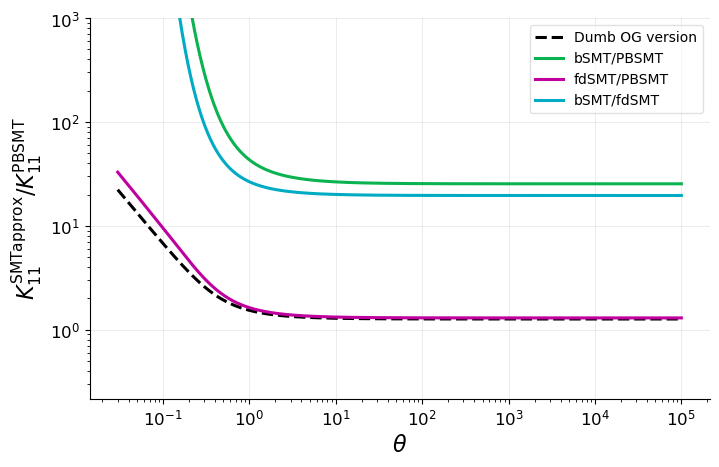

In [68]:
# def K_nm_SMT_integrand(n,m,g):
#     return lambda ω: g**m * np.exp(-g*ω**2)*ω**(2*m+3)#*φ(n,ω)

f_fd = lambda ε, η: 1/(1 + np.exp(ε - η)) 
f_b  = lambda ε, η: np.exp(-ε + η) 

def K_nm_bSMT_integrand(n,m,η): # ω^2 = ε = β 
    if n==1:
        An = 15.944
    elif n==2:
        An = 7.8182
    return lambda ε: An/2 * f_b(ε,η)*ε**(m+1)

def K_nm_fdSMT_integrand(n,m,η): # ω^2 = ε = β 
    if n==1:
        An = 15.944
    elif n==2:
        An = 7.8182
    return lambda ε: An/2 * f_fd(ε,η)*ε**(m+1)* 2/(1 + 10*ε**2)

def K_nm_PBSMT_integrand(n,m,η): # ω^2 = ε = β 
    if n==1:
        An = 15.944
    elif n==2:
        An = 7.8182
    return lambda ε: An/2 * f_fd(ε, η)*(1-f_fd(ε, η))*ε**(m+1) * 2/(1 + 10*ε**2)

def plot_Knm(n,m):
    fig, ax  = plt.subplots()

    theta_array = np.geomspace(3e-2,1e5, num=1000)
    # Original roughly
    max_ε = 1e4
    bSMT_integral =  lambda η: quad(K_nm_bSMT_integrand(n,m,η),0,max_ε )[0]
    bSMT_integral = np.vectorize(bSMT_integral)
    bSMT_vals = bSMT_integral(1/theta_array)
    
    max_ε = 100
    fdSMT_integral =  lambda η: quad(K_nm_fdSMT_integrand(n,m,η),0,max_ε )[0]
    fdSMT_integral = np.vectorize(fdSMT_integral)
    fdSMT_vals = fdSMT_integral(1/theta_array)
    
    
    # New
    PBSMT_integral = lambda η: quad(K_nm_PBSMT_integrand(n,m,η),0,max_ε )[0]
    PBSMT_integral = np.vectorize(PBSMT_integral)
    PBSMT_vals = PBSMT_integral(1/theta_array) 
    
    

    # a=1
#     # b=1.5
#     # c=0.99
#     # n=2
#     f_approx = lambda theta, a, b, n: b*(1 + (a/theta)**n)**(1/n)
#     # popt, pcov = curve_fit(f_approx,theta_array, sigma_f/sigma_f_PB, p0=[1, 1,1] ) 
#     # print(popt)
#     # ax.plot(theta_array, f_approx(theta_array, *popt))
#     # ax.plot(theta_array, f_approx(theta_array, 1,1))
    ax.plot(theta_array, sigma_f/sigma_f_PB, 'k--',label='Dumb OG version',alpha=1)
    ax.plot(theta_array, bSMT_vals/PBSMT_vals, label='bSMT/PBSMT')
    ax.plot(theta_array, fdSMT_vals/PBSMT_vals, label='fdSMT/PBSMT')
    ax.plot(theta_array, bSMT_vals/fdSMT_vals, label='bSMT/fdSMT')


    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(None,1e3)
    ax.set_ylabel(r"$K^{{\rm SMT approx}}_{{ {0} {1} }}/K^{{\rm PB SMT}}_{{ {0} {1} }}$".format(n,m))
    ax.set_xlabel(r"$\theta$")
    ax.legend()
    
plot_Knm(1,1)